In [1]:
!pip install backtrader
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/Quant/Backtrader

/content/drive/MyDrive/Colab Notebooks/Quant/Backtrader


In [4]:
import backtrader as bt 
import datetime
import yfinance as yf
from matplotlib import pyplot as plt

# ***RSI Strategy***

In [5]:
class RSIStrategy(bt.Strategy):

  params = (
    ('maperiod', 15),
    ) #Window size for RSI
  def log(self, text): #Function to print out log details (Closing price & Date)
    dt = self.datas[0].datetime.date(0)
    print(dt.isoformat(), text) 
    
  def __init__(self):
    self.dataclose = self.datas[0].close
    self.order = None
    self.rsi = bt.indicators.RSI(self.datas[0]) #Initialise the inidicator RSI

  def notify_order(self, order): #Notify the user when a new order is executed/cancelled
    if order.status in [order.Submitted, order.Accepted]: #If order status is accepted/submitted, no need to notify as it is not yet executed.
      return
        
    if order.status in [order.Completed]: #If order is executed then notify the user
      if order.isbuy(): #If buy order
        self.log('BUY EXECUTED :Price- %2f, Cost- %2f, Commission- %2f' % (order.executed.price, order.executed.value, order.executed.comm))
      elif order.issell(): #If sell order
        self.log('SELL EXECUTED :Price- %2f, Cost- %2f, Commission- %2f' % (order.executed.price, order.executed.value, order.executed.comm))
      self.bar_executed = len(self)

    elif order.status in [order.Canceled, order.Margin, order.Rejected]: #If order is cancelled, notify the same
      self.log('ORDER CANCELLED/ MARGIN/ REJECTED')
    self.order = None


  def notify_trade(self, trade): #Notify the user about profits after squarring off a trade
    if not trade.isclosed: 
      return
    self.log('OPERATION PROFIT: GROSS- %2f, NET- %2f' % (trade.pnl, trade.pnlcomm))
    
  def next(self):
    if self.order: #if order is pending, cant send another order, go ahead to next day
      return

    #if we are not in market position, we might buyp
    if not self.position:
      if self.rsi[0] <30:
        self.log('BUY CREATE - %2f' % self.dataclose[0])
        self.order = self.buy() #place a buy order, notify_order is executed for buy
      if self.rsi > 70:
        self.log('SELL CREATE - %2f' % self.dataclose[0])
        self.order = self.buy() #place a buy order, notify_order is executed for buy
        
    else: #we might sell
      if self.order == None and self.broker.get_value() > self.dataclose and self.rsi <30:
        #this block is to accommodate muptiple positions at the same time irrespective of our market position
        self.log('BUY CREATE - %2f' % self.dataclose[0])
        self.order = self.buy() #place a buy order, notify_order is executed for buy 
      if self.rsi[0] > 70:
        self.log('SELL CREATE - %2f' % self.dataclose[0])
        self.order = self.sell() #place a sell order, notify_order is executed for sell

[*********************100%***********************]  1 of 1 completed
INITIAL PORTFOLIO VALUE:  50000.0
2018-02-02 BUY CREATE - 40.125000
2018-02-05 BUY EXECUTED :Price- 39.775002, Cost- 397.750015, Commission- 0.397750
2018-02-05 BUY CREATE - 39.122501
2018-02-06 BUY EXECUTED :Price- 38.707500, Cost- 387.075005, Commission- 0.387075
2018-05-09 SELL CREATE - 46.840000
2018-05-10 SELL EXECUTED :Price- 46.935001, Cost- 392.412510, Commission- 0.469350
2018-05-10 SELL CREATE - 47.509998
2018-05-11 SELL EXECUTED :Price- 47.372501, Cost- 392.412510, Commission- 0.473725
2018-05-11 OPERATION PROFIT: GROSS- 158.250008, NET- 156.522108
2018-06-05 SELL CREATE - 48.327499
2018-06-06 BUY EXECUTED :Price- 48.407501, Cost- 484.075012, Commission- 0.484075
2018-06-06 SELL CREATE - 48.494999
2018-06-07 SELL EXECUTED :Price- 48.535000, Cost- 484.075012, Commission- 0.485350
2018-06-07 OPERATION PROFIT: GROSS- 1.274986, NET- 0.305561
2018-08-01 SELL CREATE - 50.375000
2018-08-02 BUY EXECUTED :Price- 50.

<IPython.core.display.Javascript object>

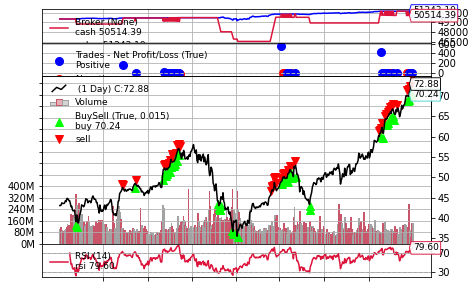

In [6]:
cerebro_rsi = bt.Cerebro() #Initialise the bot

#add the strategy
cerebro_rsi.addstrategy(RSIStrategy)
#sets the sub-folder from where data feed will be collected
datapath = 'AAPL.csv'
#set the data feed
data = bt.feeds.PandasData(dataname=yf.download('AAPL', '2018-01-01', '2019-12-31'))

cerebro_rsi.adddata(data) #add data feed to engine

cerebro_rsi.broker.setcash(50000.0) #Set initial portfolio size
cerebro_rsi.broker.setcommission(commission=0.001) #Broker commission set as 0.1%
cerebro_rsi.addsizer(bt.sizers.FixedSize, stake = 10) #No of shares transacted during an order, can be manually specified in the buy() or sell() function
initial = cerebro_rsi.broker.get_value()
print('INITIAL PORTFOLIO VALUE: ',initial) #print initial portfolio value
cerebro_rsi.run()
final = cerebro_rsi.broker.get_value()
print('\n\nFINAL PORTFOLIO VALUE: ',final) #print final portfolio value
print('PROFIT: ', (final - initial)*100/initial, '%') #print profit
figure = plt.gcf()
figure.set_size_inches(10,5)
cerebro_rsi.plot()[0][0].savefig('figure_RSI.png', dpi=300) #save figure as image file

# ***MULTIPLE INDICATOR STRATEGY***
Buy when:

1. Closes above the top line of Bolinger Band (period = 20)
2. RSI > 50
3. Volume > SMA(Volume, period = 12)

Sell when:
1. Closes below bottom line of Bollinger Band
2. RSI < 50

In [7]:
class MultipleStrategy(bt.Strategy):

  params = (('BBandsperiod', 20), ('VolumePeriod', 12),)
  def log(self, text):
    dt = self.datas[0].datetime.date(0)
    print(dt.isoformat(), text)
    
  def __init__(self):
    self.dataclose = self.datas[0].close
    self.order = None
    self.rsi = bt.indicators.RSI(self.datas[0])
    self.bband = bt.indicators.BBands(self.datas[0], period=self.params.BBandsperiod)
    self.volume_sma = bt.indicators.SMA(self.datas[0].volume, period = self.params.VolumePeriod)
    self.topline = None
    self.botline = None


  def notify_order(self, order):
    if order.status in [order.Submitted, order.Accepted]:
      return
        
    if order.status in [order.Completed]:
      if order.isbuy():
        self.log('BUY EXECUTED :Price- %2f, Cost- %2f, Commission- %2f' % (order.executed.price, order.executed.value, order.executed.comm))
      elif order.issell():
        self.log('SELL EXECUTED :Price- %2f, Cost- %2f, Commission- %2f' % (order.executed.price, order.executed.value, order.executed.comm))
      self.bar_executed = len(self)

    elif order.status in [order.Canceled, order.Margin, order.Rejected]:
      self.log('ORDER CANCELLED/ MARGIN/ REJECTED')
    self.order = None


  def notify_trade(self, trade):
    if not trade.isclosed:
      return
    self.log('OPERATION PROFIT: GROSS- %2f, NET- %2f' % (trade.pnl, trade.pnlcomm))
  
    
  def next(self):
    if self.order: #if order is pending, cant send another order, go ahead to next day
      return

    if self.dataclose[0] > self.bband.lines.top:
      self.topline = True
    if self.dataclose[0] < self.bband.lines.bot:
      self.botline = True

    #if we are not in market, we might buyp
    if not self.position:
      if self.topline and self.rsi > 50 and self.volume_sma > self.datas[0].volume:
        self.log('BUY CREATE - %2f' % self.dataclose[0])
        self.order = self.buy() #notify_order is executed for buy
      if self.botline and self.rsi <50:
        self.log('SELL CREATE - %2f' % self.dataclose[0])
        self.order = self.buy()
        
    else: #we might sell
      if self.order == None and self.broker.get_value() > self.dataclose and self.topline and self.rsi > 50 and self.volume_sma > self.datas[0].volume:
        self.log('BUY CREATE - %2f' % self.dataclose[0])
        self.order = self.buy()
      if self.botline and self.rsi <50:
        self.log('SELL CREATE - %2f' % self.dataclose[0])
        self.order = self.sell()

In [8]:
cerebro_multi = bt.Cerebro()

#add the strategy
cerebro_multi.addstrategy(MultipleStrategy)
#sets the sub-folder from where data feed will be collected
datapath = 'AAPL.csv'
#set the data feed
data = bt.feeds.PandasData(dataname=yf.download('AAPL', '2018-01-01', '2019-12-31'))

cerebro_multi.adddata(data) #add to engine

cerebro_multi.broker.setcash(50000.0)
cerebro_multi.broker.setcommission(commission=0.001) #0.1%
cerebro_multi.addsizer(bt.sizers.FixedSize, stake = 10)
initial = cerebro_multi.broker.get_value()
print('INITIAL PORTFOLIO VALUE: ',initial)
cerebro_multi.run()
final = cerebro_multi.broker.get_value()
print('\n\nFINAL PORTFOLIO VALUE: ',final)
print('PROFIT: ', (final - initial)*100/initial, '%')
figure = plt.gcf()
# figure.set_size_inches(20,20)
# cerebro_multi.plot()[0][0].savefig('figure_MultipleStrategy.png', dpi=100)

[*********************100%***********************]  1 of 1 completed
INITIAL PORTFOLIO VALUE:  50000.0
2018-01-30 SELL CREATE - 41.742500
2018-01-31 BUY EXECUTED :Price- 41.717499, Cost- 417.174988, Commission- 0.417175
2018-01-31 SELL CREATE - 41.857498
2018-02-01 SELL EXECUTED :Price- 41.792500, Cost- 417.174988, Commission- 0.417925
2018-02-01 OPERATION PROFIT: GROSS- 0.750008, NET- -0.085092
2018-02-01 SELL CREATE - 41.945000
2018-02-02 BUY EXECUTED :Price- 41.500000, Cost- 415.000000, Commission- 0.415000
2018-02-02 SELL CREATE - 40.125000
2018-02-05 SELL EXECUTED :Price- 39.775002, Cost- 415.000000, Commission- 0.397750
2018-02-05 OPERATION PROFIT: GROSS- -17.249985, NET- -18.062735
2018-02-05 SELL CREATE - 39.122501
2018-02-06 BUY EXECUTED :Price- 38.707500, Cost- 387.075005, Commission- 0.387075
2018-02-06 SELL CREATE - 40.757500
2018-02-07 SELL EXECUTED :Price- 40.772499, Cost- 387.075005, Commission- 0.407725
2018-02-07 OPERATION PROFIT: GROSS- 20.649986, NET- 19.855186
2018-

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [9]:
class GoldenCross(bt.Strategy):

  params = (('fast', 50), ('slow', 100),('ticker', 'AAPL'),('order_percentage',0.95))
  def log(self, text): #Function to print out log details (Closing price & Date)
    dt = self.datas[0].datetime.date(0)
    print(dt.isoformat(), text) 

  def __init__(self):
    self.dataclose = self.datas[0].close
    self.order = None
    self.fast_moving_average=bt.indicators.SMA(
        self.data.close,period=self.params.fast,plotname='50 day moving average'
    )
    self.slow_moving_average=bt.indicators.SMA(
        self.data.close,period=self.params.slow,plotname='200 day moving average'
    )
    self.crossover=bt.indicators.CrossOver(self.fast_moving_average,self.slow_moving_average)

  def notify_order(self, order): #Notify the user when a new order is executed/cancelled
    if order.status in [order.Submitted, order.Accepted]: #If order status is accepted/submitted, no need to notify as it is not yet executed.
      return
        
    if order.status in [order.Completed]: #If order is executed then notify the user
      if order.isbuy(): #If buy order
        self.log('BUY EXECUTED :Price- %2f, Cost- %2f, Commission- %2f' % (order.executed.price, order.executed.value, order.executed.comm))
      elif order.issell(): #If sell order
        self.log('SELL EXECUTED :Price- %2f, Cost- %2f, Commission- %2f' % (order.executed.price, order.executed.value, order.executed.comm))
      self.bar_executed = len(self)

    elif order.status in [order.Canceled, order.Margin, order.Rejected]: #If order is cancelled, notify the same
      self.log('ORDER CANCELLED/ MARGIN/ REJECTED')
    self.order = None

  def next(self):
    if self.order: #if order is pending, cant send another order, go ahead to next day
      return

    #if we are not in market position, we might buyp
    if not self.position:
      if self.crossover >0:
        self.log('BUY CREATE - %2f' % self.dataclose[0])
        self.order = self.buy() #place a buy order, notify_order is executed for buy
      if self.crossover < 0:
        self.log('SELL CREATE - %2f' % self.dataclose[0])
        self.order = self.buy() #place a buy order, notify_order is executed for buy
        
    else: #we might sell
      if self.order == None and self.broker.get_value() > self.dataclose and self.crossover >0:
        #this block is to accommodate muptiple positions at the same time irrespective of our market position
        self.log('BUY CREATE - %2f' % self.dataclose[0])
        self.order = self.buy() #place a buy order, notify_order is executed for buy 
      if self.crossover < 0:
        self.log('SELL CREATE - %2f' % self.dataclose[0])
        self.order = self.sell() #place a sell order, notify_order is executed for sell

[*********************100%***********************]  1 of 1 completed
INITIAL PORTFOLIO VALUE:  50000.0
2018-11-30 SELL CREATE - 44.645000
2018-12-03 BUY EXECUTED :Price- 46.115002, Cost- 461.150017, Commission- 0.461150
2019-03-28 BUY CREATE - 47.180000
2019-03-29 BUY EXECUTED :Price- 47.457500, Cost- 474.575005, Commission- 0.474575
2019-07-22 SELL CREATE - 51.805000
2019-07-23 SELL EXECUTED :Price- 52.115002, Cost- 467.862511, Commission- 0.521150
2019-07-29 BUY CREATE - 52.419998
2019-07-30 BUY EXECUTED :Price- 52.189999, Cost- 521.899986, Commission- 0.521900


FINAL PORTFOLIO VALUE:  50519.14617919922
PROFIT:  1.0382923583984376 %


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 720x360 with 0 Axes>

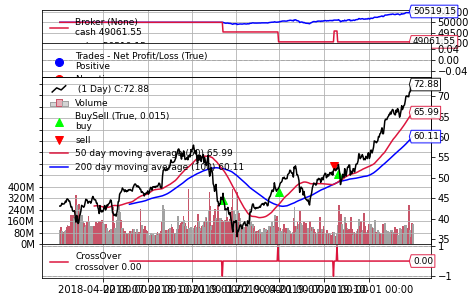

In [10]:
cerebro_rsi = bt.Cerebro() #Initialise the bot

#add the strategy
cerebro_rsi.addstrategy(GoldenCross)
#sets the sub-folder from where data feed will be collected
datapath = 'AAPL.csv'
#set the data feed
data = bt.feeds.PandasData(dataname=yf.download('AAPL', '2018-01-01', '2019-12-31'))

cerebro_rsi.adddata(data) #add data feed to engine

cerebro_rsi.broker.setcash(50000.0) #Set initial portfolio size
cerebro_rsi.broker.setcommission(commission=0.001) #Broker commission set as 0.1%
cerebro_rsi.addsizer(bt.sizers.FixedSize, stake = 10) #No of shares transacted during an order, can be manually specified in the buy() or sell() function
initial = cerebro_rsi.broker.get_value()
print('INITIAL PORTFOLIO VALUE: ',initial) #print initial portfolio value
cerebro_rsi.run()
final = cerebro_rsi.broker.get_value()
print('\n\nFINAL PORTFOLIO VALUE: ',final) #print final portfolio value
print('PROFIT: ', (final - initial)*100/initial, '%') #print profit
figure = plt.gcf()
figure.set_size_inches(10,5)
cerebro_rsi.plot()[0][0].savefig('figure_Golden_Cross.png', dpi=300) #save figure as image file

In [11]:
class MACD(bt.Strategy):

  params = (
        # Standard MACD Parameters
        ('macd1', 12),
        ('macd2', 26),
        ('macdsig', 9),
        ('atrperiod', 14),  # ATR Period (standard)
        ('atrdist', 3.0),   # ATR distance for stop price
        ('smaperiod', 30),  # SMA Period (pretty standard)
        ('dirperiod', 10),  # Lookback period to consider SMA trend direction
    )
  def log(self, text): #Function to print out log details (Closing price & Date)
    dt = self.datas[0].datetime.date(0)
    print(dt.isoformat(), text) 

  def __init__(self):
    self.dataclose = self.datas[0].close
    self.order = None
    self.macd = bt.indicators.MACD(self.data,
                                       period_me1=self.p.macd1,
                                       period_me2=self.p.macd2,
                                       period_signal=self.p.macdsig)

        # Cross of macd.macd and macd.signal
    self.mcross = bt.indicators.CrossOver(self.macd.macd, self.macd.signal)

        # To set the stop price
    self.atr = bt.indicators.ATR(self.data, period=self.p.atrperiod)

        # Control market trend
    self.sma = bt.indicators.SMA(self.data, period=self.p.smaperiod)
    self.smadir = self.sma - self.sma(-self.p.dirperiod)

  def notify_order(self, order): #Notify the user when a new order is executed/cancelled
    if order.status in [order.Submitted, order.Accepted]: #If order status is accepted/submitted, no need to notify as it is not yet executed.
      return
        
    if order.status in [order.Completed]: #If order is executed then notify the user
      if order.isbuy(): #If buy order
        self.log('BUY EXECUTED :Price- %2f, Cost- %2f, Commission- %2f' % (order.executed.price, order.executed.value, order.executed.comm))
      elif order.issell(): #If sell order
        self.log('SELL EXECUTED :Price- %2f, Cost- %2f, Commission- %2f' % (order.executed.price, order.executed.value, order.executed.comm))
      self.bar_executed = len(self)

    elif order.status in [order.Canceled, order.Margin, order.Rejected]: #If order is cancelled, notify the same
      self.log('ORDER CANCELLED/ MARGIN/ REJECTED')
    self.order = None

  def next(self):
    if self.order: #if order is pending, cant send another order, go ahead to next day
      return

    #if we are not in market position, we might buyp
    if not self.position:
      if self.mcross[0] > 0.0 and self.smadir < 0.0:
        self.log('BUY CREATE - %2f' % self.dataclose[0])
        self.order = self.buy() #place a buy order, notify_order is executed for buy
        pdist = self.atr[0] * self.p.atrdist
        self.pstop = self.data.close[0] - pdist
      if self.mcross[0] < 0.0 and self.smadir > 0.0:
        self.log('SELL CREATE - %2f' % self.dataclose[0])
        self.order = self.buy() #place a buy order, notify_order is executed for buy
        
    else: #we might sell
      if self.order == None and self.broker.get_value() > self.dataclose and self.mcross[0] > 0.0 and self.smadir < 0.0:
        #this block is to accommodate muptiple positions at the same time irrespective of our market position
        self.log('BUY CREATE - %2f' % self.dataclose[0])
        self.order = self.buy() #place a buy order, notify_order is executed for buy 
      if self.mcross[0] < 0.0 and self.smadir > 0.0:
        self.log('SELL CREATE - %2f' % self.dataclose[0])
        self.order = self.sell() #place a sell order, notify_order is executed for sell

[*********************100%***********************]  1 of 1 completed
INITIAL PORTFOLIO VALUE:  50000.0
2018-03-19 SELL CREATE - 43.825001
2018-03-20 BUY EXECUTED :Price- 43.810001, Cost- 438.100014, Commission- 0.438100
2018-04-10 BUY CREATE - 43.312500
2018-04-11 BUY EXECUTED :Price- 43.057499, Cost- 430.574989, Commission- 0.430575
2018-05-02 BUY CREATE - 44.142502
2018-05-03 BUY EXECUTED :Price- 43.970001, Cost- 439.700012, Commission- 0.439700
2018-05-25 SELL CREATE - 47.145000
2018-05-29 SELL EXECUTED :Price- 46.900002, Cost- 436.125005, Commission- 0.469000
2018-06-08 SELL CREATE - 47.924999
2018-06-11 SELL EXECUTED :Price- 47.837502, Cost- 436.125005, Commission- 0.478375
2018-07-09 BUY CREATE - 47.645000
2018-07-10 BUY EXECUTED :Price- 47.677502, Cost- 476.775017, Commission- 0.476775
2018-07-30 SELL CREATE - 47.477501
2018-07-31 SELL EXECUTED :Price- 47.575001, Cost- 456.450011, Commission- 0.475750
2018-09-07 SELL CREATE - 55.325001
2018-09-10 SELL EXECUTED :Price- 55.237499,

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 720x360 with 0 Axes>

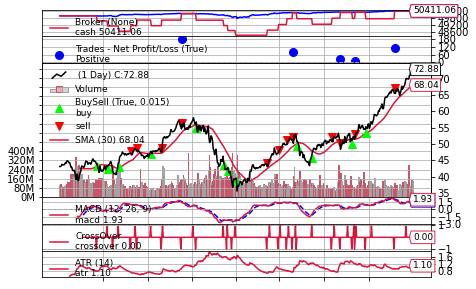

In [12]:
cerebro_rsi = bt.Cerebro() #Initialise the bot

#add the strategy
cerebro_rsi.addstrategy(MACD)
#sets the sub-folder from where data feed will be collected
datapath = 'AAPL.csv'
#set the data feed
data = bt.feeds.PandasData(dataname=yf.download('AAPL', '2018-01-01', '2019-12-31'))

cerebro_rsi.adddata(data) #add data feed to engine

cerebro_rsi.broker.setcash(50000.0) #Set initial portfolio size
cerebro_rsi.broker.setcommission(commission=0.001) #Broker commission set as 0.1%
cerebro_rsi.addsizer(bt.sizers.FixedSize, stake = 10) #No of shares transacted during an order, can be manually specified in the buy() or sell() function
initial = cerebro_rsi.broker.get_value()
print('INITIAL PORTFOLIO VALUE: ',initial) #print initial portfolio value
cerebro_rsi.run()
final = cerebro_rsi.broker.get_value()
print('\n\nFINAL PORTFOLIO VALUE: ',final) #print final portfolio value
print('PROFIT: ', (final - initial)*100/initial, '%') #print profit
figure = plt.gcf()
figure.set_size_inches(10,5)
cerebro_rsi.plot()[0][0].savefig('figure_MACD.png', dpi=300) #save figure as image file